### Data Augmentation on the Horses or Humans Dataset


 Applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results.

In [1]:
#importing necessary libraries

import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
train_dir = "horse-or-human"
valid_dir ="validation-horse-or-human"

#directory with training horse and human pictures

train_horse_dir = os.path.join(train_dir, "horses")
train_human_dir = os.path.join(train_dir, "humans")

#directory with validation horse and human pictures

valid_horse_dir = os.path.join(valid_dir, "horses")
valid_human_dir = os.path.join(valid_dir, "humans")

In [3]:
#a function to build a model

def create_model():
    "builds a CNN for binary classification"

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(300, 300, 3)),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Conv2D(16, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")

    ])

    return model

In [4]:
#constants
batch_size= 32
image_size=(300, 300)
label_mode="binary"

#instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary"
)

#optimizing the datasets for training
shuffle_buffer_size = 1000
prefetch_buffer_size =tf.data.AUTOTUNE

train_dataset_final =(train_dataset
                      .cache()
                      .shuffle(shuffle_buffer_size)
                      .prefetch(prefetch_buffer_size)
)

validation_dataset_final =(validation_dataset
                      .cache()
                      .shuffle(shuffle_buffer_size)
                      .prefetch(prefetch_buffer_size)
)


Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


##### Data Augmentation

In [5]:
#define fill mode
fill_mode ="nearest"

#create the augmentation model
data_augmentation = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300, 300, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=fill_mode),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=fill_mode),
    tf.keras.layers.RandomZoom(0.2, fill_mode=fill_mode)
])


In [12]:
def demo_augmentation(sample_image, model, num_aug):
    "take single image array, then uses a model to generate num_aug transformations"

    #instantiate preview list
    image_preview = []

    #converting input image to PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    #appending result to list
    image_preview.append(sample_image_pil)

    #applying the image augmentation and appending result to list
    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes=plt.subplots(1, num_aug+1, figsize=(12,12))  
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])  
        ax.set_axis_off() 

        if index == 0:
            ax.set_title("original")
        else:
            ax.set_title("augmented")           



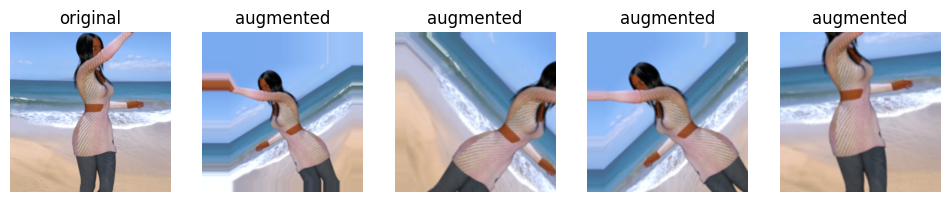

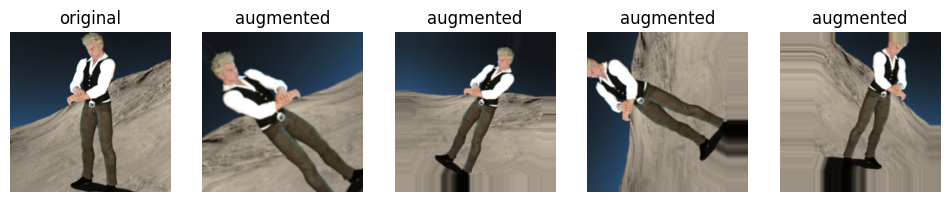

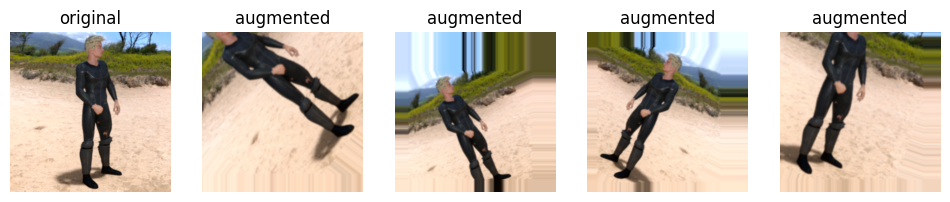

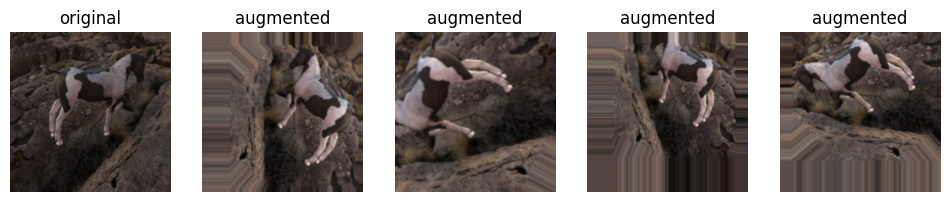

In [13]:
num_aug=4

#get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]

#apply the transformations to first 4 images
demo_augmentation(sample_batch[0], data_augmentation, num_aug)
demo_augmentation(sample_batch[1], data_augmentation, num_aug)
demo_augmentation(sample_batch[2], data_augmentation, num_aug)
demo_augmentation(sample_batch[3], data_augmentation, num_aug)


In [14]:
#now creating a model prepending data augmentation layer

model_without_aug = create_model()

model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

#compiling the model

model_with_aug.compile(loss="binary_crossentropy",
                       optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])

In [15]:
#model training

epochs = 20

history = model_with_aug.fit(
    train_dataset_final,
    epochs=epochs,
    validation_data = validation_dataset_final, verbose=2
)

Epoch 1/20
33/33 - 10s - 310ms/step - accuracy: 0.5521 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.6858
Epoch 2/20
33/33 - 7s - 201ms/step - accuracy: 0.5979 - loss: 0.6712 - val_accuracy: 0.5156 - val_loss: 0.6696
Epoch 3/20
33/33 - 6s - 195ms/step - accuracy: 0.6728 - loss: 0.6292 - val_accuracy: 0.5000 - val_loss: 0.8183
Epoch 4/20
33/33 - 7s - 203ms/step - accuracy: 0.6933 - loss: 0.5890 - val_accuracy: 0.5000 - val_loss: 0.8298
Epoch 5/20
33/33 - 7s - 201ms/step - accuracy: 0.7235 - loss: 0.5624 - val_accuracy: 0.5664 - val_loss: 0.6260
Epoch 6/20
33/33 - 7s - 200ms/step - accuracy: 0.7332 - loss: 0.5315 - val_accuracy: 0.5586 - val_loss: 0.6995
Epoch 7/20
33/33 - 7s - 200ms/step - accuracy: 0.7683 - loss: 0.5020 - val_accuracy: 0.5000 - val_loss: 1.2664
Epoch 8/20
33/33 - 7s - 201ms/step - accuracy: 0.7731 - loss: 0.4806 - val_accuracy: 0.5742 - val_loss: 0.9221
Epoch 9/20
33/33 - 7s - 203ms/step - accuracy: 0.7770 - loss: 0.4584 - val_accuracy: 0.5117 - val_loss: 1.5178


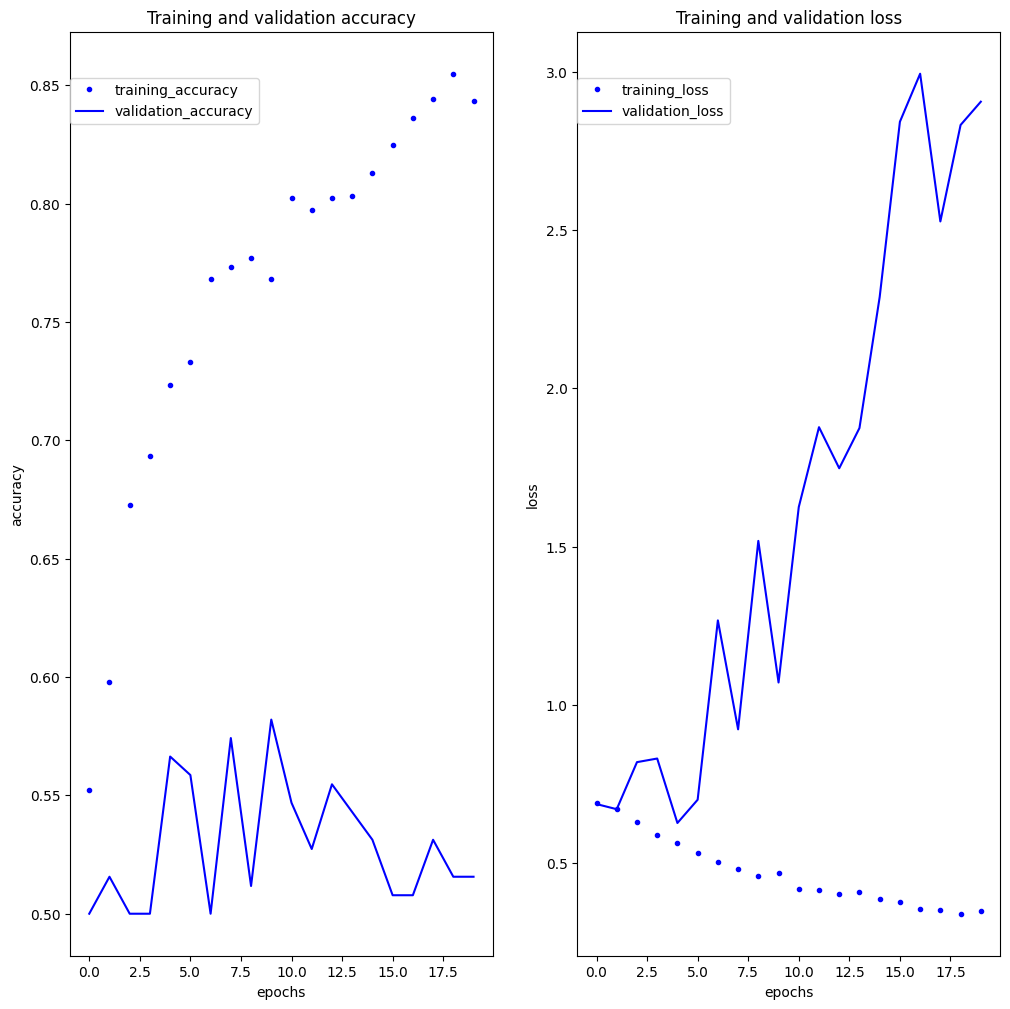

In [23]:
# Plotting accuracy and loss graphs

def plot_loss_acc(history):

    plt.subplots(1,2, figsize=(12,12))
    epochs = range(len(history.history['accuracy']))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, "b.", label="training_accuracy")
    plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Training and validation accuracy")
    plt.legend(loc=[0,0.9])

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "b.", label="training_loss")
    plt.plot(epochs, val_loss, "b-", label="validation_loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Training and validation loss")
    plt.legend(loc=[0,0.9])

plot_loss_acc(history)    

##### Observation:

As we can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the augmented data. It might also be that the background of the training images are also being learned by the model so the white background of the validation set is throwing the prediction off

In [32]:
#visualizing training and validation datasets distribution
import matplotlib.image as mpimg
def visualize_distribution(dir1, dir2):

    plt.subplots(2,8, figsize=(12,4))
    
    f1_names = os.listdir(dir1)
    f2_names = os.listdir(dir2)

    random_f1_img_paths = [os.path.join(dir1, f) for f in random.sample(f1_names, k=8)]
    random_f2_img_paths = [os.path.join(dir2, f) for f in random.sample(f2_names, k=8)]

    for inx, img_path in enumerate(random_f1_img_paths + random_f2_img_paths):
        plt.subplot(2,8,inx+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        



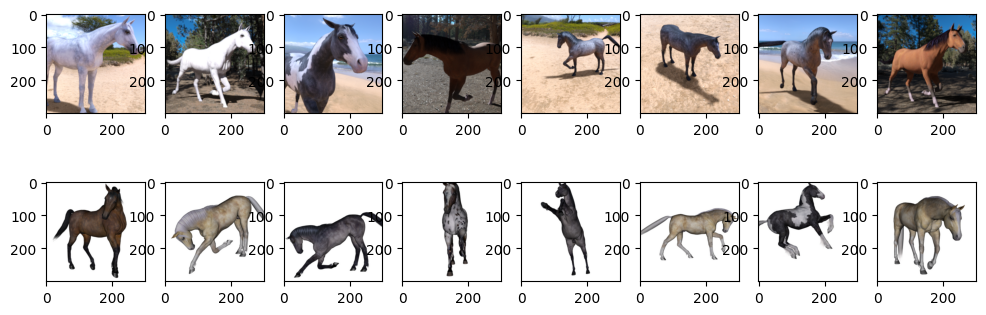

In [33]:
visualize_distribution(dir1=train_horse_dir, dir2=valid_horse_dir)

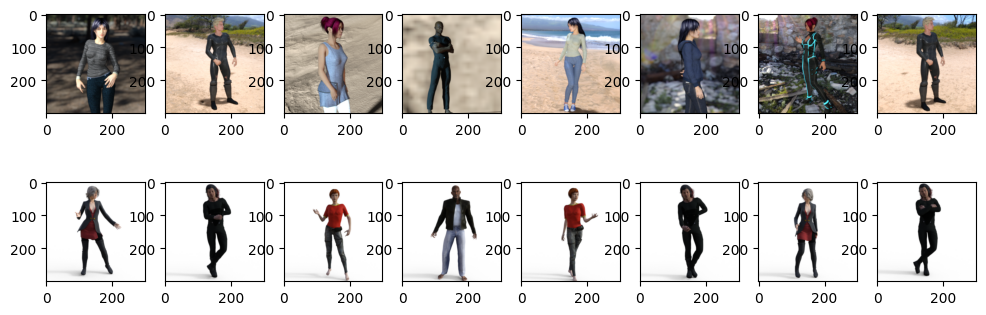

In [34]:
visualize_distribution(dir1=train_human_dir, dir2=valid_human_dir)

#####